In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ctypes import byref
import pyvisa, time, sys
import ctypes as ct
from lmfit.models import LorentzianModel
def LorentzianFit(x,y):
    """
    Fitting by Lorentzian

    Lambda function will written in __LorentzianFunc

    Lorentzian parameter will be written in __fit_param

    amplitude: 'amplitude', center frequency: 'center', sigma: 'sigma', fwhm: 'fwhm', height: 'height'
    """

    mod = LorentzianModel()
    pars = mod.guess(1-y, x=x)
    out = mod.fit(1-y, pars, x=x)

    def loren(a, x, x0, sigma): 
        return a/np.pi * sigma / ((x-x0)**2+sigma**2)  # Lorentzian template function

    return  lambda x: 1 - loren(out.values['amplitude'], x, out.values['center'], out.values['sigma']),out.values

def ConnectToGenerator(gen_address):
    """
    Initialization of generator using VISA protocol

    Input: VISA format address (see VISA manual)

    """
    rm = pyvisa.ResourceManager() # VISA initilization
    try:
        generator = rm.open_resource(gen_address) # connection to a generator
    except:
        print("Error!!! Check a generator and/or address!!!")
    else:
        print(generator.query("*IDN?")) # check SCPI commands
        generator.write('OUTPut OFF') # Output off
        return generator
    
    
    
# 'TCPIP::169.254.2.20::inst0::INSTR'
gen_address = 'USB0::0x0AAD::0x0054::177040::INSTR'
gen = ConnectToGenerator(gen_address)

# From phdefin.h
LIB_VERSION = "3.0"
HISTCHAN = 65536
MAXDEVNUM = 8
MODE_HIST = 0
FLAG_OVERFLOW = 0x0040

# Measurement parameters, these are hardcoded since this is just a demo
binning = 0 # you can change this
offset = 0
# tacq = int (meas_step_time*1000) # Measurement time in millisec, you can change this
syncDivider = 1 # you can change this 
CFDZeroCross0 = 10 # you can change this (in mV)
CFDLevel0 = 100 # you can change this (in mV)
CFDZeroCross1 = 10 # you can change this (in mV)
CFDLevel1 = 50 # you can change this (in mV)
cmd = 0

# Variables to store information read from DLLs
counts = (ct.c_uint * HISTCHAN)()
dev = []
libVersion = ct.create_string_buffer(b"", 8)
hwSerial = ct.create_string_buffer(b"", 8)
hwPartno = ct.create_string_buffer(b"", 8)
hwVersion = ct.create_string_buffer(b"", 8)
hwModel = ct.create_string_buffer(b"", 16)
errorString = ct.create_string_buffer(b"", 40)
resolution = ct.c_double()
countRate0 = ct.c_int()
countRate1 = ct.c_int()
flags = ct.c_int()

phlib = ct.CDLL("phlib64.dll")

def closeDevices():
    for i in range(0, MAXDEVNUM):
        phlib.PH_CloseDevice(ct.c_int(i))
#     exit(0)

def tryfunc(retcode, funcName):
    if retcode < 0:
        phlib.PH_GetErrorString(errorString, ct.c_int(retcode))
        print("PH_%s error %d (%s). Aborted." % (funcName, retcode,\
              errorString.value.decode("utf-8")))
        closeDevices()

phlib.PH_GetLibraryVersion(libVersion)
print("Library version is %s" % libVersion.value.decode("utf-8"))
if libVersion.value.decode("utf-8") != LIB_VERSION:
    print("Warning: The application was built for version %s" % LIB_VERSION)

# outputfile = open("dlldemo.out", "w+")

# outputfile.write("Binning           : %d\n" % binning)
# outputfile.write("Offset            : %d\n" % offset)
# outputfile.write("AcquisitionTime   : %d\n" % tacq)
# outputfile.write("SyncDivider       : %d\n" % syncDivider)
# outputfile.write("CFDZeroCross0     : %d\n" % CFDZeroCross0)
# outputfile.write("CFDLevel0         : %d\n" % CFDLevel0)
# outputfile.write("CFDZeroCross1     : %d\n" % CFDZeroCross1)
# outputfile.write("CFDLevel1         : %d\n" % CFDLevel1)

print("\nSearching for PicoHarp devices...")
print("Devidx     Status")

for i in range(0, MAXDEVNUM):
    retcode = phlib.PH_OpenDevice(ct.c_int(i), hwSerial)
    if retcode == 0:
        print("  %1d        S/N %s" % (i, hwSerial.value.decode("utf-8")))
        dev.append(i)
    else:
        if retcode == -1: # ERROR_DEVICE_OPEN_FAIL
            print("  %1d        no device" % i)
        else:
            phlib.PH_GetErrorString(errorString, ct.c_int(retcode))
            print("  %1d        %s" % (i, errorString.value.decode("utf8")))

# In this demo we will use the first PicoHarp device we find, i.e. dev[0].
# You can also use multiple devices in parallel.
# You can also check for specific serial numbers, so that you always know 
# which physical device you are talking to.

if len(dev) < 1:
    print("No device available.")
    closeDevices()
print("Using device #%1d" % dev[0])
print("\nInitializing the device...")

tryfunc(phlib.PH_Initialize(ct.c_int(dev[0]), ct.c_int(MODE_HIST)), "Initialize")

# Only for information
tryfunc(phlib.PH_GetHardwareInfo(dev[0], hwModel, hwPartno, hwVersion),\
        "GetHardwareInfo")
print("Found Model %s Part no %s Version %s" % (hwModel.value.decode("utf-8"),\
    hwPartno.value.decode("utf-8"), hwVersion.value.decode("utf-8")))

print("\nCalibrating...")
tryfunc(phlib.PH_Calibrate(ct.c_int(dev[0])), "Calibrate")

tryfunc(phlib.PH_SetSyncDiv(ct.c_int(dev[0]), ct.c_int(syncDivider)), "SetSyncDiv")

tryfunc(
    phlib.PH_SetInputCFD(ct.c_int(dev[0]), ct.c_int(0), ct.c_int(CFDLevel0),\
                         ct.c_int(CFDZeroCross0)),\
    "SetInputCFD"
)

tryfunc(
    phlib.PH_SetInputCFD(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(CFDLevel1),\
                         ct.c_int(CFDZeroCross1)),\
    "SetInputCFD"
)

tryfunc(phlib.PH_SetBinning(ct.c_int(dev[0]), ct.c_int(binning)), "SetBinning")
tryfunc(phlib.PH_SetOffset(ct.c_int(dev[0]), ct.c_int(offset)), "SetOffset")
tryfunc(phlib.PH_GetResolution(ct.c_int(dev[0]), byref(resolution)), "GetResolution")

# Note: after Init or SetSyncDiv you must allow 100 ms for valid count rate readings
time.sleep(0.2)

tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(0), byref(countRate0)),\
        "GetCountRate")
tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(1), byref(countRate1)),\
        "GetCountRate")

print("Resolution=%lf Countrate0=%d/s Countrate1=%d/s" % (resolution.value,\
      countRate0.value, countRate1.value))

tryfunc(phlib.PH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(65535)),\
        "SetStopOverflow")


Rohde&Schwarz,SMB100A,1406.6000k03/177040,4.20.028.58

Library version is 3.0

Searching for PicoHarp devices...
Devidx     Status
  0        S/N 1030137
  1        no device
  2        no device
  3        no device
  4        no device
  5        no device
  6        no device
  7        no device
Using device #0

Initializing the device...
Found Model PicoHarp 300 Part no 930004 Version 2.0

Calibrating...
Resolution=4.000000 Countrate0=11428540/s Countrate1=7945660/s


In [2]:
tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(0), byref(countRate0)),\
        "GetCountRate")

tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(1), byref(countRate1)),\
        "GetCountRate")

print("Resolution=%lf Countrate0=%d/s Countrate1=%d/s" % (resolution.value,\
      countRate0.value, countRate1.value))


tryfunc(phlib.PH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(65535)),\
        "SetStopOverflow")
if countRate1.value>5.5e5:
    print('Warning!!! Decrease power!!!')

Resolution=4.000000 Countrate0=11428530/s Countrate1=157670/s


In [15]:
tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(0), byref(countRate0)),\
        "GetCountRate")

tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(1), byref(countRate1)),\
        "GetCountRate")

print("Resolution=%lf Countrate0=%d/s Countrate1=%d/s" % (resolution.value,\
      countRate0.value, countRate1.value))


tryfunc(phlib.PH_SetStopOverflow(ct.c_int(dev[0]), ct.c_int(1), ct.c_int(65535)),\
        "SetStopOverflow")
if countRate1.value>7e6:
    print('Warning!!! Decrease power!!!')


# Measurments parameters
# Generator parameters
# gen.write('OUTPut Off')
f_start = 2.7 # GH
f_stop =  3# GHz
f_step = 0.005 # GHz
n_step = 50+1
freq = np.linspace(f_start, f_stop, n_step)
gen_level = -15 #dBm

# Measurements parameters
meas_step_time = 0.1# Measurement step time (one point measurement), s


tacq = int (meas_step_time*1000) # Measurement time in millisec, you can change this
meas_counts = []
meas_count_rate = []
print("\nTime step %d ms" % tacq)
print("Frequency from",f_start,"GHz to",f_stop,"GHz")
print("Number of steps:", freq.shape[0])
print("Generator Power:",gen_level,"dBm")
start_time = time.time()
#___________________________________________________________________________
#reference meas


try:
    gen.write('LEVEL '+str(gen_level)+'dBm')
    gen.write('OUTPut ON')

    for j in freq[::1]:


        gen.write('Freq 100 kHz')
#         gen.write('Freq 200 MHz')



        tryfunc(phlib.PH_ClearHistMem(ct.c_int(dev[0]), ct.c_int(0)), "ClearHistMeM")
        tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(1), byref(countRate1)),\
                "GetCountRate")
        ref_rate1  = countRate1.value
        tryfunc(phlib.PH_StartMeas(ct.c_int(dev[0]), ct.c_int(tacq)), "StartMeas")
        waitloop = 0
        ctcstatus = ct.c_int(0)
        while ctcstatus.value == 0:
            tryfunc(phlib.PH_CTCStatus(ct.c_int(dev[0]), byref(ctcstatus)), "CTCStatus")
            waitloop+=1

        tryfunc(phlib.PH_StopMeas(ct.c_int(dev[0])), "StopMeas")
        tryfunc(phlib.PH_GetHistogram(ct.c_int(dev[0]), byref(counts), ct.c_int(0)),\
                "GetHistogram")
        tryfunc(phlib.PH_GetFlags(ct.c_int(dev[0]), byref(flags)), "GetFlags")

        ref_point = 0
        for i in range(0, HISTCHAN):
            ref_point += counts[i]


        if flags.value & FLAG_OVERFLOW > 0:
            print("  Overflow.")

        time.sleep(0.025)


        gen.write('Freq '+str(j) +'GHz')

        time.sleep(0.025)
        # Always use block 0 if not routing
        tryfunc(phlib.PH_ClearHistMem(ct.c_int(dev[0]), ct.c_int(0)), "ClearHistMeM")


        tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(0), byref(countRate0)),\
                "GetCountRate")
        tryfunc(phlib.PH_GetCountRate(ct.c_int(dev[0]), ct.c_int(1), byref(countRate1)),\
                "GetCountRate")


        tryfunc(phlib.PH_StartMeas(ct.c_int(dev[0]), ct.c_int(tacq)), "StartMeas")

        waitloop = 0
        ctcstatus = ct.c_int(0)
        while ctcstatus.value == 0:
            tryfunc(phlib.PH_CTCStatus(ct.c_int(dev[0]), byref(ctcstatus)), "CTCStatus")
            waitloop+=1

        tryfunc(phlib.PH_StopMeas(ct.c_int(dev[0])), "StopMeas")
        tryfunc(phlib.PH_GetHistogram(ct.c_int(dev[0]), byref(counts), ct.c_int(0)),\
                "GetHistogram")
        tryfunc(phlib.PH_GetFlags(ct.c_int(dev[0]), byref(flags)), "GetFlags")
        integralCount = 0
        for i in range(0, HISTCHAN):
            integralCount += counts[i]

        meas_counts.append(integralCount/ref_point)
        meas_count_rate.append(countRate1.value)
        if flags.value & FLAG_OVERFLOW > 0:
            print("  Overflow.")


    gen.write('OUTPut OFF')

    print("Finish for", time.time()-start_time, "seconds")

    file_name = time.strftime('20%y_%m_%d_%H%M%S.txt') 
    outputfile = open(file_name, "w+")
    outputfile.write("Time step: %d ms\n" % tacq)
    outputfile.write("Generator Power: "+str(gen_level)+" dBm\n")
    for i in np.array([freq,np.array(meas_counts)]).transpose():
        outputfile.write(str(i[0])+' '+str(i[1])+'\n')
    outputfile.close()
    print("Data save to", file_name)

    g_fit = LorentzianFit(freq, np.array(meas_counts))
    # closeDevices()
except:
    gen.write('OUTPut OFF')

Resolution=4.000000 Countrate0=11428530/s Countrate1=7960700/s
Warning!!! Decrease power!!!

Time step 100 ms
Frequency from 2.7 GHz to 3 GHz
Number of steps: 51
Generator Power: -15 dBm
Finish for 15.761922359466553 seconds
Data save to 2024_01_26_182303.txt


Text(0.5, 1.0, 'ODMR Spectra')

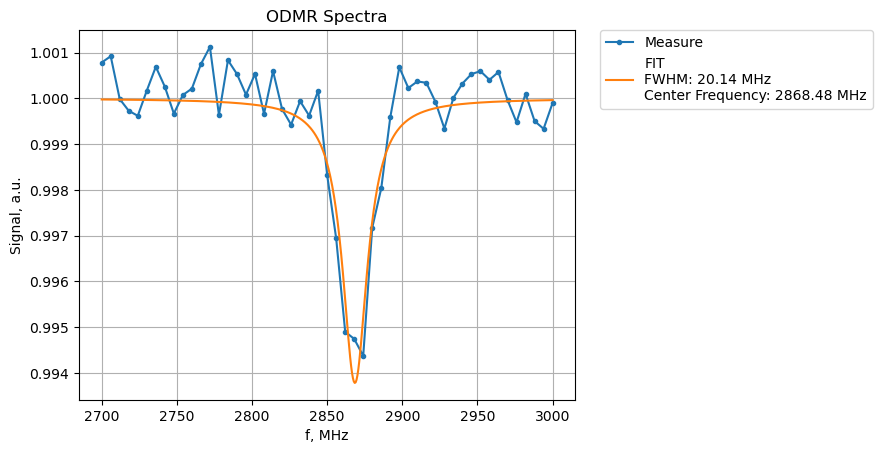

In [16]:
plt.plot(freq*1e3, np.array(meas_counts), '.-')
freq_fit = np.linspace(f_start, f_stop, 500)
plt.plot(freq_fit*1e3, g_fit[0](freq_fit), '-')
# plt.axvline(x=2.87*1e3,color = 'r', linestyle='--')
plt.legend(['Measure', 'FIT\nFWHM: '+ str(round(g_fit[1]['fwhm']*1000,2))+' MHz\nCenter Frequency: '+ str(round(g_fit[1]['center']*1000,2))+' MHz', '2870 MHz Line'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('f, MHz')
plt.ylabel('Signal, a.u.')
#plt.xlim(2800,2890)
#plt.ylim(0.93,1.1)
plt.grid()
plt.title('ODMR Spectra')

In [17]:
gen.close()
closeDevices()